# Cognitive Services Personalizer 
https://github.com/Azure-Samples/cognitive-services-personalizer-samples の日本語訳です。

このチュートリアルでは、顧客がどのタイプのコーヒーを注文すべきかを提案する Personalizer ループシステム をシミュレートしています。ユーザーとその好みは、[user dataset](users.json)に保存されます。コーヒーに関する情報は、[coffee dataset](coffee.json)にも格納されています。

このノートブックは、ユーザーが Web サイトで行う対話操作をシミュレートし、データセットからランダムなユーザー、時間帯、天気の種類を選択します。 ユーザー情報の概要は次のとおりです。

|顧客  コンテキスト|時間帯|天気|
|--|--|--|
|Alice<br>Bob<br>Cathy<br>Dave|朝<br>午後<br>夜|晴れ<br>雨<br>雪| 

Personalizer が時間の経過と共に学習できるよう、この "システム" は各人物のコーヒーの選択に関する情報も把握しています。

|コーヒー - アクションの特徴|温度の種類|原産地|焙煎の種類|オーガニック|
|--|--|--|--|--|
|カプチーノ|ホット|ケニア|深煎り|オーガニック|
|コールド ブリュー|アイス|ブラジル|浅煎り|オーガニック|
|アイス モカ|アイス|エチオピア|浅煎り|オーガニックでない|
|ラテ|ホット|ブラジル|深煎り|オーガニックでない|
 
Personalizer ループの**目的**は、できるだけ多くの場合にユーザーと最も相性の良いコーヒーを見つけることです。
このチュートリアルのコードは、[Personalizer Samples GitHub リポジトリ](https://github.com/Azure-Samples/cognitive-services-personalizer-samples/blob/master/samples/azurenotebook/Personalizer.ipynb)にあります。

## シミュレーションの仕組み

実行中のシステムの開始時点では、Personalizer からの提案がうまくいくのはたった 20% から 30% です。 この成功は、Personalizer の Reward API に返される報酬 (スコアは 1) によって示されます。 いくつかの Rank と Reward の呼び出しの後、システムは改善されます。

最初の 10,000 リクエストの後、オフライン評価を実行します。これにより、Personalizer がデータを見直し、より良い学習ポリシーを提案することができます。新しい学習ポリシーを適用し、2,000 リクエストでノートを再度実行します。ループのパフォーマンスが向上します。

## ランク(Rank)と報酬(Reward)の呼び出し

Personalizer サービスへの数千回の呼び出しごとに、ノートブックは **Rank** リクエストを REST API に送信します。

* ランクまたはリクエストイベントの一意のID
* コンテキスト: ランダムに選択したユーザー、天気、時間帯 - ウェブサイトやモバイルデバイス上のユーザーをシミュレートします。
* アクションと特徴量: Personalizer が提案する際に基づく "すべて" のコーヒーデータ

システムは、コーヒーの選択肢のランクを受け取り、その予測と、同じ時間帯と天候についてのユーザーの既知の選択肢を比較します。既知の選択肢が予測された選択肢と同じであれば、 **Reward** 1 が Personalizer に送られます。そうでない場合、報酬は 0 です。

> [!注意]
> これはシミュレーションなので、報酬のアルゴリズムはシンプルです。実際のシナリオでは、このアルゴリズムは、報酬スコアを決定するためにビジネス ロジックを使用する必要があります (場合によっては、顧客の経験のさまざまな側面に対する重みが使用されます)。

## 前提条件

* [Azure Personalizer リソース](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesPersonalizer) 
    * すでにPersonalizerリソースを使用している場合は、そのリソースの Azure ポータルで[データをクリア](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-settings#clear-data-for-your-learning-loop)してください。

* Jupyter Notebook

ファイルの説明。

* [Personalizer.ipynb](Personalization.ipynb) は、このチュートリアルのための Jupyter ノートブックです。
* [User dataset](users.json) は JSON オブジェクトに格納されています。
* [Coffee dataset](coffee.json) は JSON オブジェクトに格納されています。
* [リクエスト例JSON](example-rankrequest.json) は、Rank API への POST リクエスト用のフォーマットです。


## パーソナルサイザーリソースの設定

Azure ポータルで、[Personalizer リソース](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesPersonalizer) を設定し、**モデルの更新頻度** を **15秒** に設定し、**報酬の待機時間**を **15秒** に設定します。これらの設定は、[構成]タブの[リソース管理]セクションにあります。

|設定|値|
|--|--|
|モデルの更新頻度|15 秒|
|報酬の待機時間|15 秒|

これらの値は、このチュートリアルで変化を示すために非常に短い期間に設定しています。これらの値は、Personalizer ループで目標を達成していることを確認しない限り、本番環境では使用しないでください。

## Jupyter Notebook を設定する

1. カーネルを `Python 3.6` に変更します。
1. `Personalizer.ipynb` ファイルを開きます。


## ノートブックのセルを実行

各実行可能セルを実行して、結果が返るまで待ちます。

セルの隣の括弧に `*` の代わりに数字が表示されれば、実行が完了したことがわかります。エラーが出た場合は続行しないでください。

以降のセクションでは、各セルがプログラムで実行する内容と出力に期待する内容について説明します。

### Python モジュールを読み込む

必要な Python モジュールを含めます。セルには出力がありません。

In [1]:
import json
import matplotlib.pyplot as plt
import random 
import requests
import time
import uuid
import datetime

### Personalizer のリソースキーと名前を設定する

Azure ポータルから、Personalizer リソースの**キーとエンドポイント**メニューから、キーとエンドポイントを見つけます。`<your-resource-name>` の値をPersonalizer リソースの名前に変更します。`<your-resource-key>` の値を Personalizer のキーに変更してください。

セルには何も出力されません。

In [9]:
# 'personalization_base_url'と 'resource_key' を有効なエンドポイント値に置き換えます。
personalization_base_url = "https://<your-resource-name>.cognitiveservices.azure.com/"
resource_key = "<your-resource-key>"

### 現在のデータと時間を出力

反復関数 `iterations` の開始時刻と終了時刻を記録するには、この関数を用いる。

これらのセルには出力がありません。この関数が呼び出されると、現在の日付と時刻が出力されます。

In [5]:
# 現在の日付を出力する
def currentDateTime():
    currentDT = datetime.datetime.now()
    print (str(currentDT))

### 最終モデルの更新日時を取得

関数 `get_last_updated` が呼び出されると、モデルが最後に更新された日時を出力します。

これらのセルは出力されません。この関数が呼び出されると、最後のモデル学習日が出力されます。

この関数は GET REST API を利用して[モデルのプロパティを取得](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/GetModelProperties)しています。


In [10]:
# モデルの最終更新日のための変数を初期化します。
modelLastModified = ""

In [11]:
def get_last_updated(currentModifiedDate):
    
    print('-----checking model')
    
    # モデルプロパティの取得
    response = requests.get(personalization_model_properties_url, headers = headers, params = None)
    
    print(response)
    print(response.json())
    
    # lastModifiedTimeを取得
    lastModifiedTime = json.dumps(response.json()["lastModifiedTime"])
    
    if (currentModifiedDate != lastModifiedTime):
        currentModifiedDate = lastModifiedTime
        print(f'-----model updated: {lastModifiedTime}')

### ポリシーとサービスの設定を取得

これら 2 つの REST コールでサービスの状態を検証します。

これらのセルには出力がありません。この関数は呼ばれたときにサービスの設定を出力します。

In [13]:
def get_service_settings():
    
    print('-----checking service settings')
    
    # 学習ポリシーを取得する
    response = requests.get(personalization_model_policy_url, headers = headers, params = None)
    
    print(response)
    print(response.json())
    
    # サービス設定を取得する
    response = requests.get(personalization_service_configuration_url, headers = headers, params = None)
    
    print(response)
    print(response.json())


### REST 呼び出し用の URL を構築し、JSON データファイルを読み込む

このセルは次を実行します。

* REST 呼び出しで使用される URL を構築します。
* Personalizer のリソースキーを使用してセキュリティヘッダを設定します。
* Rank イベント ID のランダムシードを設定します。
* JSON データファイルを読み込む
* `get_last_updated` メソッドを呼び出す (出力例では、学習ポリシーが削除されています)
* `get_service_settings` メソッドを呼び出します。

セルには、関数 `get_last_updated` と `get_service_settings` の呼び出しによる出力があります。


In [15]:
# URLを構築
personalization_rank_url = personalization_base_url + "personalizer/v1.0/rank"
personalization_reward_url = personalization_base_url + "personalizer/v1.0/events/" #add "{eventId}/reward"
personalization_model_properties_url = personalization_base_url + "personalizer/v1.0/model/properties"
personalization_model_policy_url = personalization_base_url + "personalizer/v1.0/configurations/policy"
personalization_service_configuration_url = personalization_base_url + "personalizer/v1.0/configurations/service"
headers = {'Ocp-Apim-Subscription-Key' : resource_key, 'Content-Type': 'application/json'}

# コンテキスト
users = "users.json"

# action features
coffee = "coffee.json"

# ランク要求用の空のJSON
requestpath = "example-rankrequest.json"

# ramdom の初期化
random.seed(time.time())

userpref = None 
rankactionsjsonobj = None 
actionfeaturesobj = None

with open(users) as handle:
    userpref = json.loads(handle.read())

with open(coffee) as handle:
    actionfeaturesobj = json.loads(handle.read())
    
with open(requestpath) as handle:
    rankactionsjsonobj = json.loads(handle.read())  
    
get_last_updated(modelLastModified)
get_service_settings()

print(f'User count {len(userpref)}')
print(f'Coffee count {len(actionfeaturesobj)}')

-----checking model
<Response [200]>
{'creationTime': '2020-12-10T04:50:52+00:00', 'lastModifiedTime': '2021-01-22T02:51:11+00:00'}
-----model updated: "2021-01-22T02:51:11+00:00"
-----checking service settings
<Response [200]>
{'name': 'fde432dc01b1471ebc354f49ec319e4f', 'arguments': '--cb_explore_adf --epsilon 0.20000000298023224 --power_t 0 -l 0.001 --cb_type mtr -q ::'}
<Response [200]>
{'rewardWaitTime': 'PT15S', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': 'PT15S', 'logRetentionDays': -1, 'modelAutoPublish': True, 'stagedModelHistoryLength': 10, 'lastConfigurationEditDate': '2021-01-22T02:51:10', 'learningMode': 'Online'}
User count 4
Coffee count 4


出力の `rewardWaitTime` と `modelExportFrequency` がともに 15秒 に設定されていることを確認してください。
    
```console
-----checking model
<Response [200]>
{'creationTime': '0001-01-01T00:00:00+00:00', 'lastModifiedTime': '0001-01-01T00:00:00+00:00'}
-----model updated: "0001-01-01T00:00:00+00:00"
-----checking service settings
<Response [200]>
{...learning policy...}
<Response [200]>
{'rewardWaitTime': '00:00:15', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': '00:00:15', 'logRetentionDays': -1}
User count 4
Coffee count 4
```


### 最初の REST コールのトラブルシューティング

この前のセルは、Personalizer に呼び出す最初のセルです。出力される REST ステータスコードが `<Response [200]>` であることを確認してください。404 などのエラーが出ても、リソースキーと名前が正しいことを確認したら、ノートブックをリロードします。

コーヒーのカウントとユーザー数が両方とも **4** になっていることを確認し、エラーが出た場合は、3 つの JSON ファイルをすべてアップロードしたことを確認してください。

### Azure ポータルでメトリックグラフを設定する

このチュートリアルの後半では、10,000 リクエストのロングラン処理をブラウザから更新テキストボックスで見ることができます。長時間実行中のプロセスが終了したときに、グラフや合計で見るとわかりやすいかもしれません。この情報を表示するには、リソースで提供されているメトリクスを使用します。サービスへのリクエストを完了した時点でグラフを作成し、長期実行プロセスが進行している間は定期的にグラフを更新することができます。

1. Azure ポータルで、Personalizer リソースを選択します。
1. リソースナビゲーションで、監視の下の **メトリック** を選択します。
1. グラフで、**メトリックの追加** を選択します。
1. リソースとメトリック名前空間はすでに設定されています。必要なのは、**Successful Calls** のメトリックと **合計** の集計だけです。
1. 時間フィルタを過去 4 時間に変更します。

![直近 4 時間の成功した呼び出し用のメトリックを追加して、Azure portal でメトリック グラフを設定します。](./media/metric-chart-setting.png)

チャートに 3 つの成功したコールが表示されるはずです。

### 固有のイベントIDを生成する

この関数は、ランクコールごとに固有の ID を生成します。この ID は、ランクと報酬の呼び出し情報を識別するために使用されます。この値は、Web ビュー ID やトランザクション ID などのビジネスプロセスから生成される可能性があります。

セルには出力がありません。この関数は、呼び出されたときに一意の ID を出力します。

In [16]:
def add_event_id(rankjsonobj):
    eventid = uuid.uuid4().hex
    rankjsonobj["eventId"] = eventid
    return eventid

### ランダムなユーザー、天気、時間帯を取得する

この関数は、ユニークなユーザー、天気、時間帯を選択し、それらの項目を JSON オブジェクトに追加して Rank リクエストに送信します。

セルには何も出力されません。この関数が呼び出されると、ランダムなユーザー名、ランダムな天気、ランダムな時間帯が返されます。

4人のユーザーのリストとその設定 - 簡潔にするためにいくつかの設定のみを表示しています。

```json
{
  "Alice": {
    "Sunny": {
      "Morning": "Cold brew",
      "Afternoon": "Iced mocha",
      "Evening": "Cold brew"
    }...
  },
  "Bob": {
    "Sunny": {
      "Morning": "Cappucino",
      "Afternoon": "Iced mocha",
      "Evening": "Cold brew"
    }...
  },
  "Cathy": {
    "Sunny": {
      "Morning": "Latte",
      "Afternoon": "Cold brew",
      "Evening": "Cappucino"
    }...
  },
  "Dave": {
    "Sunny": {
      "Morning": "Iced mocha",
      "Afternoon": "Iced mocha",
      "Evening": "Iced mocha"
    }...
  }
}
```

In [17]:
def add_random_user_and_contextfeatures(namesoption, weatheropt, timeofdayopt, rankjsonobj):   
    name = namesoption[random.randint(0,3)]
    weather = weatheropt[random.randint(0,2)]
    timeofday = timeofdayopt[random.randint(0,2)]
    rankjsonobj['contextFeatures'] = [{'timeofday': timeofday, 'weather': weather, 'name': name}]
    return [name, weather, timeofday]


### すべてのコーヒーデータを追加

この関数は、Rank リクエストに送信する JSON オブジェクトにコーヒーのリスト全体を追加します。

セルには何も出力されません。この関数が呼び出されると `rankjsonobj` が変更されます。


コーヒーの特徴を1つにまとめた例です。

```json
{
    "id": "Cappucino",
    "features": [
    {
        "type": "hot",
        "origin": "kenya",
        "organic": "yes",
        "roast": "dark"
        
    }
}
```

In [18]:
def add_action_features(rankjsonobj):
    rankjsonobj["actions"] = actionfeaturesobj

### Rank API の予測と既知のユーザーの好みを比較する

この関数は、Rank API が呼び出された後に、各イテレーションごとに呼び出されます。

この関数は、天気や時間帯に基づいたユーザーのコーヒーの好みと、それらのフィルターに対するパーソナライザの提案を比較します。候補が一致した場合はスコアが 1、そうでない場合はスコアが 0 となります。

セルには何も出力されません。この関数は、呼び出されたときにスコアを出力します。

In [19]:
def get_reward_from_simulated_data(name, weather, timeofday, prediction):
    if(userpref[name][weather][timeofday] == str(prediction)):
        return 1 
    return 0

### ランクと報酬への呼び出しをループする

次のセルはノートブックの主な作業で、ランダムなユーザーを取得し、コーヒーリストを取得し、両方を Rank API に送信します。予測とユーザーの好みを比較し、報酬をパーソナライズサービスに送り返します。

このループは `num_requests` 回分実行されます。Personalizer はモデルを作成するために Rank と Reward を数千回呼び出す必要があります。

Rank API に送られる JSON の例は以下の通りです。簡潔のため、コーヒーのリストは完全ではありません。コーヒーの JSON 全体は `coffee.json` で見ることができます。



```json
{ 
   'contextFeatures':[ 
      { 
         'timeofday':'Evening',
         'weather':'Snowy',
         'name':'Alice'
      }
   ],
   'actions':[ 
      { 
         'id':'Cappucino',
         'features':[ 
            { 
               'type':'hot',
               'origin':'kenya',
               'organic':'yes',
               'roast':'dark'
            }
         ]
      }
        ...残りのコーヒーリスト
   ],
   'excludedActions':[ 

   ],
   'eventId':'b5c4ef3e8c434f358382b04be8963f62',
   'deferActivation':False
}
```

Rank API に送信される JSON:

```console
{'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Sunny', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '5001bcfe3bb542a1a238e6d18d57f2d2', 'deferActivation': False}
```

Rank API からの JSON レスポンス:

```
{
    'ranking': [
        {'id': 'Latte', 'probability': 0.85 },
        {'id': 'Iced mocha', 'probability': 0.05 },
        {'id': 'Cappucino', 'probability': 0.05 },
        {'id': 'Cold brew', 'probability': 0.05 }
    ], 
    'eventId': '5001bcfe3bb542a1a238e6d18d57f2d2', 
    'rewardActionId': 'Latte'
}
```

最後に、各ループは、ユーザー、天候、時間帯、および決定された報酬のランダムな選択を示しています。報酬が 1 の場合は、Personalizer リソースがユーザー、天気、時間帯に応じた正しいコーヒーの種類を選択したことを示します。

```console
1 Alice Rainy Morning Latte 1
```

この関数では、以下を使用します。

* Rank: [ランクを取得する](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/Rank)ための POST REST API。
* Reward: [報酬をレポートする](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/Reward)ための POST REST API。

In [20]:
def iterations(n, modelCheck, jsonFormat):

    i = 1
    
    # デフォルトの報酬値 - 予測に失敗したと仮定
    reward = 0

    # Print out dateTime
    #currentDateTime()

    # 結果を集めてグラフに集約する
    total = 0
    rewards = []
    count = []

    # ユーザー、天気、時間帯のデフォルトリスト
    namesopt = ['Alice', 'Bob', 'Cathy', 'Dave']
    weatheropt = ['Sunny', 'Rainy', 'Snowy']
    timeofdayopt = ['Morning', 'Afternoon', 'Evening']
    
    
    while(i <= n):

        # イベントに関連付けるためのユニークなIDを作成します
        eventid = add_event_id(jsonFormat)

        # ランダムにサンプルを生成する
        [name, weather, timeofday] = add_random_user_and_contextfeatures(namesopt, weatheropt, timeofdayopt, jsonFormat)

        # ランクにアクション特徴量を追加する
        add_action_features(jsonFormat) 

        # ランクに送るJSONを表示する
        #print('To: ', jsonFormat)    

        # アクションを選択する - Personalizerから予測を得る
        response = requests.post(personalization_rank_url, headers = headers, params = None, json = jsonFormat)

        # ランク予測を表示
        #print ('From: ',response.json())    

        # Personalizer サービスのレコメンデーションをシミュレーションデータと比較し、報酬値を生成する
        prediction = json.dumps(response.json()["rewardActionId"]).replace('"','')
        reward = get_reward_from_simulated_data(name, weather, timeofday, prediction)

        # 反復結果を表示
        print(f'   {i} {currentDateTime()} {name} {weather} {timeofday} {prediction} {reward} ')

        # サービスに報酬を送る
        response = requests.post(personalization_reward_url + eventid + "/reward", headers = headers, params= None, json = { "value" : reward })

        # ランクリクエストNごとに、合計を正しく計算します
        total = total + reward

        # N回の反復ごとに、最後に更新されたモデルの日付と時刻を取得します
        if(i % modelCheck == 0):

            print("**** 10% of loop found")
            get_last_updated(modelLastModified) 

        # 集計してグラフを読みやすくする
        if(i % 100 == 0):
            print("**** aggregating rewards")
            rewards.append(total)
            count.append(i)
            total = 0

        i = i + 1
        
    # dateTimeを出力します
    #currentDateTime()
    
    return [count, rewards]

## 10,000回の繰り返しを実行

Personalizer ループを 10,000回 繰り返し実行します。これは長時間の実行です。ノートブックを実行しているブラウザを閉じないでください。Azureポータルのメトリクスチャートを定期的に更新して、サービスへの総コール数を確認します。ループの繰り返しごとにランクと報酬のコールである 20,000 コール程度になったら、繰り返しは終了です。

## 注意
10,000 回繰り返すと `4～5` 時間かかりますので注意してください。

In [1]:
# 最大イテレーション数
num_requests = 10000

# 最終変更日をN％の時間で確認 - 現在は10％
lastModCheck = int(num_requests * .10)

jsonTemplate = rankactionsjsonobj

# メインイテレーション
[count, rewards] = iterations(num_requests, lastModCheck, jsonTemplate)


## Personalizer による改善を確認するためのグラフ結果

`count`と` rewards`からチャートを作成します。

In [24]:
def createChart(x, y):
    plt.plot(x, y)
    plt.xlabel("Batch of rank events")
    plt.ylabel("Correct recommendations per batch")
    plt.show()

## 10,000ランクリクエストのグラフを実行

関数 `createChart` を実行する。

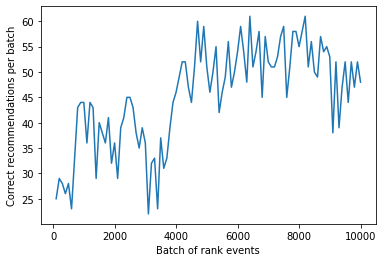

In [25]:
createChart(count, rewards)

## チャートを読む

このグラフは、現在のデフォルトの学習ポリシーでのモデルの成功率を示しています。

![このグラフには、テスト期間中に現在の学習ポリシーが成功したことが示されています。](./media/azure-notebook-chart-results.png)


理想的な目標は、テストが終了するまでに、このループの平均成功率が **100%** から探索を差し引いた割合に近くなることです。探索の既定値は **20%** です。

`100-20=80`

この探索値は、Azure ポータルの Personalizer リソースの [構成] ページで確認できます。

Rank API へのデータをもとに、より良い学習ポリシーを見つけるためには、Personalizer ループのポータルで[オフライン評価](https://docs.microsoft.com/ja-jp/azure/cognitive-services/personalizer/how-to-offline-evaluation)を実行してください。




## オフライン評価の実行

1. Azure ポータルで、Personalizer リソースの **評価** ページを開きます。
1. **評価の作成**を選択します。
1. ループ評価の評価名と日付範囲の必要なデータを入力します。日付範囲には、評価に重点を置いている日のみを含める必要があります。

    ![Azure portal で、Personalizer リソースの [評価] ページを開きます。 [評価の作成] を選択します。 評価名と日付範囲を入力します。](./media/create-offline-evaluation.png)

このオフライン評価を実行する目的は、このループで使用される特徴量とアクションに対して、より良い学習ポリシーがあるかどうかを判断することです。より良い学習ポリシーを見つけるには、**[最適化の検出]** がオンになっていることを確認してください。

1. **OK** を選択して評価を開始します。
1. この**評価**ページには、新しい評価と現在のステータスが表示されます。データの量によっては、この評価に時間がかかる場合があります。数分後にこのページに戻り、結果を確認することができます。
1. 評価が完了したら、評価を選択して、**さまざまな学習ポリシーの比較**を選択します。これは、利用可能な学習ポリシーと、それらがデータを使ってどのように動作するかを示しています。
1. 表の中で一番上の学習ポリシーを選択し、**適用**を選択します。これにより、"最適な" 学習ポリシーがモデルに適用され、再トレーニングが行われます。

## モデルの更新頻度を5分に変更

1. Azure ポータルで、Personalizer リソース上で、リソース管理セクションの下の構成タブを選択します。
1. **モデルの更新頻度**と**報酬の待機時間**を **5分** に変更し、**保存**を選択します。

[報酬の待機時間](https://docs.microsoft.com/azure/cognitive-services/personalizer/concept-rewards#reward-wait-time)、[モデルの更新頻度](https://docs.microsoft.com/azure/cognitive-services/personalizer/how-to-settings#model-update-frequency)についてはこちらをご覧ください。


In [26]:
# 新しい学習ポリシーと時間を明確にする
get_service_settings()

-----checking service settings
<Response [200]>
{'name': 'fde432dc01b1471ebc354f49ec319e4f', 'arguments': '--cb_explore_adf --epsilon 0.20000000298023224 --power_t 0 -l 0.001 --cb_type mtr -q ::'}
<Response [200]>
{'rewardWaitTime': 'PT15S', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': 'PT15S', 'logRetentionDays': -1, 'modelAutoPublish': True, 'stagedModelHistoryLength': 10, 'lastConfigurationEditDate': '2021-01-22T02:51:10', 'learningMode': 'Online'}


出力の `rewardWaitTime` と `modelExportFrequency` がともに 5分 に設定されていることを確認します。

```console
-----checking model
<Response [200]>
{'creationTime': '0001-01-01T00:00:00+00:00', 'lastModifiedTime': '0001-01-01T00:00:00+00:00'}
-----model updated: "0001-01-01T00:00:00+00:00"
-----checking service settings
<Response [200]>
{...learning policy...}
<Response [200]>
{'rewardWaitTime': '00:05:00', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': '00:05:00', 'logRetentionDays': -1}
User count 4
Coffee count 4
```

## 2,000回の実験を繰り返して新しい学習ポリシーを検証する

ノートブックに戻り、同じループを実行して続行しますが、2,000 回だけ繰り返します。Azure ポータルのメトリクスチャートを定期的に更新して、サービスへの総コール数を確認します。ループの繰り返しごとにランクと報酬のコールである 4,000 コール程度になったら、繰り返しは終了です。

In [0]:
# max iterations
num_requests = 2000

# check last mod date N% of time - currently 10%
lastModCheck2 = int(num_requests * .10)

jsonTemplate2 = rankactionsjsonobj

# main iterations
[count2, rewards2] = iterations(num_requests, lastModCheck2, jsonTemplate2)

## 2,000ランクリクエストのチャートを実行

`createChart`関数を実行します。

In [0]:
createChart(count2,rewards2)


## 2 つ目のグラフを確認する

2 つ目のグラフでは、ユーザーの好みに合ったランクの予測が明らかに増加していることが示されます。

![2 つ目のグラフでは、ユーザーの好みに合ったランクの予測が明らかに増加していることが示されます。](./media/azure-notebook-chart-results-happy-graph.png)


## リソースのクリーンアップ

チュートリアルシリーズを続行する予定がない場合は、次のリソースをクリーンアップしてください。

* Personalizer リソースを削除します。